In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
pd.set_option('float_format', '{:2f}'.format)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
loan = pd.read_csv('new_loan_data.csv', index_col='UniqueID')
print(loan.shape)
loan.head(2)

(90528, 38)


,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,AVERAGE_ACCT_AGE(mon),CREDIT_HISTORY_LENGTH(mon),borrower_age
UniqueID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
420825,50578,58400,89.550000,67,22807,45,1441,1984-01-01,Salaried,2018-03-08,6,1998,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35
537409,47145,65550,73.230000,67,22807,45,1502,1985-07-31,Self employed,2018-09-26,6,1998,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,0,0,0,0,0,1991,0,0,1,0,1,23,23,34


First we'll try to examine the data in 2D visualisation:

In [6]:
loan_dummies = pd.get_dummies(loan.drop(columns=['loan_default']),drop_first=True)
print(loan_dummies.shape)

X = loan_dummies
y = loan.loan_default

(90528, 13696)


In [7]:
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(X)

X_pca_scaled = PCA(n_components=2).fit_transform(X_scaled)

Text(0.5, 1.0, 'Segment visualization')

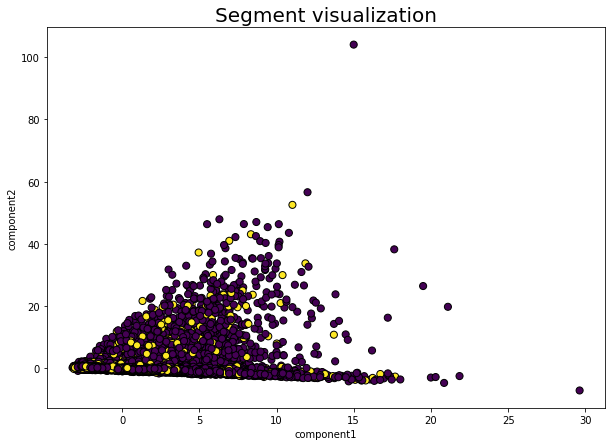

In [8]:
plt.figure(figsize=(10,7))
plt.scatter(X_pca_scaled[:, 0], 
            X_pca_scaled[:, 1], 
            c=list(y), s=50, edgecolor='k')
plt.xlabel('component1')
plt.ylabel('component2')
plt.title('Segment visualization',fontsize=20)

> There's no clear visual differnce between the two group (default=purple and non-default=yellow)

In [9]:
loan.head(1)

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,AVERAGE_ACCT_AGE(mon),CREDIT_HISTORY_LENGTH(mon),borrower_age
UniqueID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
420825,50578,58400,89.550000,67,22807,45,1441,1984-01-01,Salaried,2018-03-08,6,1998,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35


---
# Modeling

first I'll drop features that won't be used in the models:
 - Some features have too many categories and in my opinion aren't relevant for loan default prediction (supplier_id, Current_pincode_ID an so on). 
 - Date features (relevant data was exracted from them in preprocessing)
 - Descriptive features
 
**The main goal in these models is to maximize TPR (minimun undetected loan defaults) - the most expensive senario for the lender, while FP (false default alert) will probably result in a phone call or a meeting with the borrower - reasonable error price.**

In [10]:
# dateset for modeling:

model_loan = loan.drop(columns=['branch_id','supplier_id','manufacturer_id','Current_pincode_ID',
                                'Date.of.Birth','DisbursalDate','PERFORM_CNS.SCORE.DESCRIPTION',
                               'Employee_code_ID'])

In [11]:
# converting relevant features into categorical:
    
model_loan['State_ID'] = model_loan['State_ID'].astype(object)
# model_loan['Employee_code_ID'] = model_loan['Employee_code_ID'].astype(object)

In [12]:
# converting binary features to bool type:

for col in model_loan.columns:
    if model_loan[col].nunique()==2:
        model_loan[col]=model_loan[col].astype(bool)

In [13]:
loan_dummies = pd.get_dummies(model_loan,drop_first=False)
print(loan_dummies.shape)

(90528, 47)


In [14]:
loan_dummies.head(2)

,disbursed_amount,asset_cost,ltv,Employment.Type,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,AVERAGE_ACCT_AGE(mon),CREDIT_HISTORY_LENGTH(mon),borrower_age,State_ID_1,State_ID_2,State_ID_3,State_ID_4,State_ID_5,State_ID_6,State_ID_7,State_ID_8,State_ID_9,State_ID_10,State_ID_11,State_ID_12,State_ID_13,State_ID_14,State_ID_15,State_ID_16,State_ID_17,State_ID_18
UniqueID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
420825,50578,58400,89.550000,True,True,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,35,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
537409,47145,65550,73.230000,True,True,False,False,False,False,598,1,1,1,27600,50200,0,0,0,0,0,1991,0,0,1,0,True,23,23,34,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## Looking for imbalanced data

In [15]:
loan_dummies.loan_default.value_counts(normalize=True)

False   0.797941
True    0.202059
Name: loan_default, dtype: float64

I'll be using `stratify` paramter for spliting the minor group of default loan with the same proportion in the train and test sets.

In [16]:
train, test = train_test_split(loan_dummies, test_size = 0.2, random_state=7, stratify=loan.loan_default)
train.shape, test.shape

((72422, 47), (18106, 47))

In [17]:
print(f'train "loan_default" dist:\n-------------------------\n{train.loan_default.value_counts(normalize=True)}\n\n')
print(f'test  "loan_default" dist:\n-------------------------\n{test.loan_default.value_counts(normalize=True)}')

train "loan_default" dist:
-------------------------
False   0.797934
True    0.202066
Name: loan_default, dtype: float64


test  "loan_default" dist:
-------------------------
False   0.797968
True    0.202032
Name: loan_default, dtype: float64


### Basic modeling for reference:

In [18]:
X_train = train.drop(columns='loan_default')
y_train = train.loan_default

X_test = test.drop(columns='loan_default')
y_test = test.loan_default

In [19]:
clf = LogisticRegression().fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [20]:
print('Train: \n------------')
print(classification_report(y_train, y_train_pred, clf.classes_))
print('\n')
print('Test: \n------------')
print(classification_report(y_test, y_test_pred, clf.classes_))

Train: 
------------
              precision    recall  f1-score   support

       False       0.80      1.00      0.89     57788
        True       0.00      0.00      0.00     14634

   micro avg       0.80      0.80      0.80     72422
   macro avg       0.40      0.50      0.44     72422
weighted avg       0.64      0.80      0.71     72422



Test: 
------------
              precision    recall  f1-score   support

       False       0.80      1.00      0.89     14448
        True       0.00      0.00      0.00      3658

   micro avg       0.80      0.80      0.80     18106
   macro avg       0.40      0.50      0.44     18106
weighted avg       0.64      0.80      0.71     18106



In [21]:
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred),index=clf.classes_, columns=clf.classes_))

       False  True 
False  14448      0
True    3658      0


> **The model predicted all the samples as non-default loans - unacceptable for the bussiness. I'll try to balance between the data classes**

### balaced classes model for reference:

**Adding more samples for minor class:**

(only for the train set so it won't effect the test results!)

In [22]:
train_major = train[train.loan_default==False]
print(train_major.shape)
train_minor = train[train.loan_default==True]
print(train_minor.shape)

(57788, 47)
(14634, 47)


In [23]:
train_balanced = pd.concat([train_minor.sample(frac=4, replace=True),
                            train_major])

print(train_balanced.shape)
train_balanced.loan_default.value_counts(normalize=True)

(116324, 47)


True    0.503215
False   0.496785
Name: loan_default, dtype: float64

Now the data set is balanced. I'll try to run the same basic model again.

---

## Logistic Regression classifier as base model:

In [24]:
X_train = train_balanced.drop(columns='loan_default')
y_train = train_balanced.loan_default

X_test = test.drop(columns='loan_default')
y_test = test.loan_default

In [28]:
clf = LogisticRegression().fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [29]:
print('Train: \n------------')
print(classification_report(y_train, y_train_pred, clf.classes_))
print('-----')
print('Test: \n------------')
print(classification_report(y_test, y_test_pred, clf.classes_))

Train: 
------------
              precision    recall  f1-score   support

       False       0.58      0.49      0.53     57788
        True       0.56      0.65      0.60     58536

   micro avg       0.57      0.57      0.57    116324
   macro avg       0.57      0.57      0.57    116324
weighted avg       0.57      0.57      0.57    116324

-----
Test: 
------------
              precision    recall  f1-score   support

       False       0.85      0.50      0.63     14448
        True       0.25      0.66      0.36      3658

   micro avg       0.53      0.53      0.53     18106
   macro avg       0.55      0.58      0.50     18106
weighted avg       0.73      0.53      0.57     18106



In [30]:
cnf_matrix = pd.DataFrame(confusion_matrix(y_test, y_test_pred),index=clf.classes_, columns=clf.classes_)
print(cnf_matrix)

       False  True 
False   7181   7267
True    1228   2430


> After balancing the clasess, the model performs better but still can do better. I'll run other models and tune hyperparamteres for reaching better results

### (basic) Random Forest

In [34]:
clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=60,
                             n_jobs=-1).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [35]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances.head(10)

,importance
ltv,0.168095
disbursed_amount,0.150363
PERFORM_CNS.SCORE,0.089285
asset_cost,0.076968
borrower_age,0.052594
PRI.SANCTIONED.AMOUNT,0.051597
PRI.CURRENT.BALANCE,0.050885
CREDIT_HISTORY_LENGTH(mon),0.040203
PRIMARY.INSTAL.AMT,0.039541
AVERAGE_ACCT_AGE(mon),0.031364


Random Forest results are easy to interpret. The above table shows the importance of each feature to determine if the loan would default.

In [36]:
print('Train: \n------------')
print(classification_report(y_train, y_train_pred, clf.classes_))
print('\n')
print('Test: \n------------')
print(classification_report(y_test, y_test_pred, clf.classes_))

Train: 
------------
              precision    recall  f1-score   support

       False       0.69      0.61      0.65     57788
        True       0.65      0.73      0.69     58536

   micro avg       0.67      0.67      0.67    116324
   macro avg       0.67      0.67      0.67    116324
weighted avg       0.67      0.67      0.67    116324



Test: 
------------
              precision    recall  f1-score   support

       False       0.86      0.59      0.70     14448
        True       0.28      0.63      0.39      3658

   micro avg       0.60      0.60      0.60     18106
   macro avg       0.57      0.61      0.55     18106
weighted avg       0.75      0.60      0.64     18106



In [37]:
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred),index=clf.classes_, columns=clf.classes_))

       False  True 
False   8543   5905
True    1351   2307


## Building custom scoring function for the bussiness

Accuracy score is simply a ratio of correctly predicted observation to the total observations. 
It doesn't always the best way to assess model performance.
As said before, I prefer better Recall score over Precision (f1 score represent beta=1 for equale impartance of recall and precision). Let's assume the bussiness had a research and found that **the fbeta in which the costs of recall and precision erorrs are balanced is 3**

According to this senario, I'll build a new scorer for assess the performance of a model.

In [38]:
from sklearn.metrics import precision_score, recall_score, make_scorer

In [39]:
def fbeta(y_true, y_pred, beta=3):
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    return (1+beta**2)*(p*r)/((beta**2*p)+r)

In [40]:
fbeta_scorer = make_scorer(fbeta)

### Using the new scorer with Logistic Regression:

In [41]:
lr = GridSearchCV(LogisticRegression(),param_grid={'C':[1,5,10,15]}, scoring=fbeta_scorer, n_jobs=-1)
lr.fit(X_train, y_train)

lr_model = lr.best_estimator_
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

In [42]:
print('Train: \n------------')
print(classification_report(y_train, y_train_pred, lr.classes_))
print('\n')
print('Test: \n------------')
print(classification_report(y_test, y_test_pred, lr.classes_))

Train: 
------------
              precision    recall  f1-score   support

       False       0.58      0.49      0.53     57788
        True       0.56      0.65      0.60     58536

   micro avg       0.57      0.57      0.57    116324
   macro avg       0.57      0.57      0.57    116324
weighted avg       0.57      0.57      0.57    116324



Test: 
------------
              precision    recall  f1-score   support

       False       0.85      0.50      0.63     14448
        True       0.25      0.66      0.36      3658

   micro avg       0.53      0.53      0.53     18106
   macro avg       0.55      0.58      0.50     18106
weighted avg       0.73      0.53      0.57     18106



In [43]:
cnf_matrix = pd.DataFrame(confusion_matrix(y_test, y_test_pred),index=lr.classes_, columns=lr.classes_)
print(cnf_matrix)

       False  True 
False   7181   7267
True    1228   2430


In [44]:
f_beta_LM = fbeta(y_test, y_test_pred)

> Indeed the recall score improved on expense of precision score.

### Random Forest with GridSearch and custom scoring:

In [45]:
rf = GridSearchCV(RandomForestClassifier(n_estimators=100),
                  param_grid={'min_samples_leaf': [50,60,70,80],'criterion':['gini','entropy']},
                  scoring=fbeta_scorer, n_jobs=-1)
rf.fit(X_train, y_train)

rf_model = rf.best_estimator_
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [46]:
rf.best_params_

{'criterion': 'entropy', 'min_samples_leaf': 50}

In [47]:
rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [48]:
print('Train: \n------------')
print(classification_report(y_train, y_train_pred, rf.classes_))
print('\n')
print('Test: \n------------')
print(classification_report(y_test, y_test_pred, rf.classes_))

Train: 
------------
              precision    recall  f1-score   support

       False       0.70      0.63      0.66     57788
        True       0.66      0.73      0.70     58536

   micro avg       0.68      0.68      0.68    116324
   macro avg       0.68      0.68      0.68    116324
weighted avg       0.68      0.68      0.68    116324



Test: 
------------
              precision    recall  f1-score   support

       False       0.86      0.60      0.71     14448
        True       0.28      0.62      0.39      3658

   micro avg       0.60      0.60      0.60     18106
   macro avg       0.57      0.61      0.55     18106
weighted avg       0.74      0.60      0.64     18106



In [49]:
cnf_matrix = pd.DataFrame(confusion_matrix(y_test, y_test_pred),index=rf.classes_, columns=rf.classes_)
print(cnf_matrix)

       False  True 
False   8683   5765
True    1405   2253


In [50]:
f_beta_RF = fbeta(y_test, y_test_pred)

**NOTE:** Not presented here all steps I did for hyper parameters tuning to evoide over fitting of the train set.

### SVM:

All kernel methods of this model are based on distance so scaling is required. Also, because it's relatively slow, I'll reduce the dimensions of the dataset.

##### PCA:

In [51]:

steps = [('scaler',MinMaxScaler()),('pca', PCA(n_components=30)), ('svm', SVC())]

pipe = Pipeline(steps=steps)

params_grid = {'svm__C': [1, 10, 100, 1000],
               'svm__kernel': ['rbf', 'sigmoid']}

gs_svm = GridSearchCV(pipe, params_grid, n_jobs=-1, scoring=fbeta_scorer, cv=5)
gs_svm.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta), verbose=0)

In [52]:
gs_svm.best_params_

{'svm__C': 1, 'svm__kernel': 'sigmoid'}

In [53]:
svm_model = gs_svm.best_estimator_

y_train_pred_svm = svm_model.predict(X_train)
y_test_pred_svm = svm_model.predict(X_test)

In [54]:
print('Train: \n------------')
print(classification_report(y_train, y_train_pred_svm, svm_model.classes_))
print('\n')
print('Test: \n------------')
print(classification_report(y_test, y_test_pred_svm, svm_model.classes_))

Train: 
------------
              precision    recall  f1-score   support

       False       0.60      0.47      0.53     57788
        True       0.57      0.69      0.62     58536

   micro avg       0.58      0.58      0.58    116324
   macro avg       0.58      0.58      0.58    116324
weighted avg       0.58      0.58      0.58    116324



Test: 
------------
              precision    recall  f1-score   support

       False       0.86      0.47      0.61     14448
        True       0.25      0.69      0.36      3658

   micro avg       0.52      0.52      0.52     18106
   macro avg       0.55      0.58      0.49     18106
weighted avg       0.73      0.52      0.56     18106



In [55]:
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred_svm),
                   index=svm_model.classes_, columns=svm_model.classes_))

       False  True 
False   6847   7601
True    1146   2512


In [56]:
f_beta_SVM = fbeta(y_test, y_test_pred_svm)

> SMV (along with PCA) provides relatively good results of recall score - 70% and mild  precision score. So far, this is the best performance model for classifying defaults.

## Gaussian Naive Bayes

Usually this model doesn't provieds the best result among other models but its fast and could suprise in a certain dataset\scorer.

In [57]:
from sklearn.naive_bayes import GaussianNB

In [58]:
steps = [('scaler',StandardScaler()),('gnb', GaussianNB())]

pipe = Pipeline(steps=steps)

gnb_model = pipe.fit(X_train, y_train)

In [64]:
y_train_pred_gnb = gnb_model.predict(X_train)
y_test_pred_gnb = gnb_model.predict(X_test)

In [65]:
print('Train: \n------------')
print(classification_report(y_train, y_train_pred_gnb, gnb_model.classes_))
print('\n')
print('Test: \n------------')
print(classification_report(y_test, y_test_pred_gnb, gnb_model.classes_))

Train: 
------------
              precision    recall  f1-score   support

       False       0.60      0.19      0.29     57788
        True       0.52      0.88      0.65     58536

   micro avg       0.53      0.53      0.53    116324
   macro avg       0.56      0.53      0.47    116324
weighted avg       0.56      0.53      0.47    116324



Test: 
------------
              precision    recall  f1-score   support

       False       0.85      0.18      0.30     14448
        True       0.21      0.87      0.34      3658

   micro avg       0.32      0.32      0.32     18106
   macro avg       0.53      0.53      0.32     18106
weighted avg       0.72      0.32      0.31     18106



In [66]:
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred_gnb),
                   index=gnb_model.classes_, columns=gnb_model.classes_))

       False  True 
False   2669  11779
True     486   3172


In [67]:
f_beta_GNB = fbeta(y_test, y_test_pred_gnb)
f_beta_GNB

0.6625864265870115

> Gaussian Naive Bayes model provides great recall scores for True default values (~90%) but very low precision performance - almost like labelling all samples as True default. It mean that too many unnecessary check up calls, meetings and paper work will be done for good borrowers.

### Gradient boosting

This kind of model fit a sequence of weak learners (AdaBoost) so I'll trim the trees with max depth of only 3.

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

In [69]:

gb = GridSearchCV(GradientBoostingClassifier(n_estimators=200),
                  param_grid={'max_depth': [3,5],'learning_rate':[0.01,0.03,0.05]},
                  scoring=fbeta_scorer, n_jobs=-1, cv=5)

gb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 5], 'learning_rate': [0.01, 0.03, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta), verbose=0)

In [70]:
gb.best_params_

{'learning_rate': 0.05, 'max_depth': 5}

In [71]:
gb_model = gb.best_estimator_

y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)

In [72]:
print('Train: \n------------')
print(classification_report(y_train, y_train_pred_gnb, gnb_model.classes_))
print('\n')
print('Test: \n------------')
print(classification_report(y_test, y_test_pred_gnb, gnb_model.classes_))

Train: 
------------
              precision    recall  f1-score   support

       False       0.60      0.19      0.29     57788
        True       0.52      0.88      0.65     58536

   micro avg       0.53      0.53      0.53    116324
   macro avg       0.56      0.53      0.47    116324
weighted avg       0.56      0.53      0.47    116324



Test: 
------------
              precision    recall  f1-score   support

       False       0.85      0.18      0.30     14448
        True       0.21      0.87      0.34      3658

   micro avg       0.32      0.32      0.32     18106
   macro avg       0.53      0.53      0.32     18106
weighted avg       0.72      0.32      0.31     18106



In [73]:
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                   index=gnb_model.classes_, columns=gnb_model.classes_))

       False  True 
False   8270   6178
True    1291   2367


In [74]:
f_beta_GB = fbeta(y_test, y_test_pred)
f_beta_GB

0.5708153471435118

## Comparing the results using ROC

So far I covered manually the model scores and confusion matrix to determine which model outperformed the other. Another way to compare between models is using ROC curve and the area under the curve (AUC). As for ROC, FPR and the TPR are evaluated for every probability threshold, and the result is a graph of the trade-off between TPR and FPR. Whereas larger AUC represent a better model.

**Note:** In any case, if enough time provided, I would prefer manual interpretation of the result for choosing the best fit for the business case.

### ROC example

In [75]:
from sklearn.metrics import roc_curve, roc_auc_score

In [76]:
y_pred_probs = gb.predict_proba(X_test)
pd.DataFrame(y_pred_probs, columns=gb.classes_)

y_pred_probs_gbn = gnb_model.predict_proba(X_test)
pd.DataFrame(y_pred_probs_gbn, columns=gnb_model.classes_).head(3)

,False,True
0,0.065286,0.934714
1,0.001397,0.998603
2,0.029458,0.970542


In [77]:
y = y_test
scores = y_pred_probs[:, 1]
scores_gbn = y_pred_probs_gbn[:, 1]

In [78]:
fpr, tpr, thresholds = roc_curve(y, scores, pos_label=True)
fpr2, tpr2, thresholds2 = roc_curve(y, scores_gbn, pos_label=True)

res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
res = pd.DataFrame({'FPR': fpr2, 'TPR': tpr2, 'Threshold': thresholds2})

res[['TPR', 'FPR', 'Threshold']][:60:15]

,TPR,FPR,Threshold
0,0.000000,0.000000,2.000000
15,0.003554,0.002422,1.000000
30,0.006561,0.004014,1.000000
45,0.008748,0.005883,0.999999


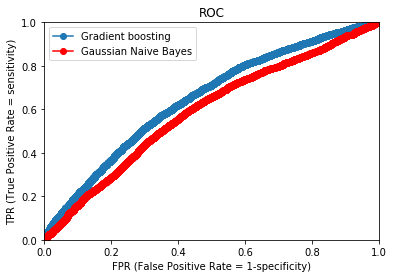

In [79]:
plt.plot(fpr, tpr, '-o')
plt.plot(fpr2, tpr2, '-o',c='r')

plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(['Gradient boosting','Gaussian Naive Bayes'])
plt.show()

> The closer the curve to the top-left corner - the better. Because I have custom scorer it won't necessarily be aligned with the AOC score.

In [81]:
#  GB vs GNB
roc_auc_score(y==True, scores), roc_auc_score(y==True, scores_gbn)

(0.6485478247588531, 0.5925550129965905)

### Comparing models using custom score (fbeta)

In [82]:
models_scores = {'GB':f_beta_GB, 'GNB':f_beta_GNB, 'RF':f_beta_RF, 'LM':f_beta_LM, 'SVM':f_beta_SVM }

In [83]:
pd.DataFrame(data=models_scores, index=['Beta_score']).T.sort_values('Beta_score', ascending=False)

,Beta_score
GNB,0.662586
SVM,0.583711
GB,0.570815
LM,0.570168
RF,0.550318


## Conclutions and further research

* I didn't assessed model performance with accuracy scoring because I believe a custom scorer are more relevant for this case.
* After manualy examining the CM and recall\precision score I would have choose to use SVM model.
* According to the custom fbeta score (assumed different weights for precision and recall), GNB performs best. Validating beta value will change the results.
* For some features only top 0.01% percentile were labeled as outiers and were removed (some feature were not modified at all). I would have try to remove more outliers and see if the results improve.
*  Adding more features such as `Employee_code_ID` that may have latent information of the ability of the borrower to fully return the loan.
* Try KNN model accuracy (I assume it will have good results like SMV as for they both use distance kernels).
* More hyper parameters tuning using wider GridSearch for reaching higher accuracy.
* Applying boosting methods on different models: boosting iteration the samples that were misclassified in the previous iteration are given higher weights, while the correctly-classified samples are given lower weights. 